In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import copy
import random
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import time

# Hugging Face imports
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("✅ Dependencies installed and imported successfully!")
print(f"🔥 CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")

✅ Dependencies installed and imported successfully!
🔥 CUDA Available: False


In [2]:
class GeneDataLoader:
    """Load and preprocess gene data from Hugging Face"""
    
    def __init__(self):
        self.dataset = None
        self.embeddings = None
        self.labels = None
        self.label_encoder = LabelEncoder()
    
    def load_gene_dataset(self, dataset_name: str = "EsaSinthia/dengue-embeddings-dna2vec"):
        """
        Load gene dataset from Hugging Face - EsaSinthia/dengue-embeddings-dna2vec
        """
        
        print(f"📥 Loading dataset: {dataset_name}")
        try:
            self.dataset = load_dataset(dataset_name)
            print(f"✅ Dataset loaded successfully!")
            print(f"📊 Dataset info: {self.dataset}")
            return self.process_dengue_embeddings_data()
        except Exception as e:
            print(f"❌ Error loading dataset: {e}")
            return False
    
    def process_dengue_embeddings_data(self):
        """Process the dengue-embeddings-dna2vec dataset"""
        if self.dataset is None:
            print("❌ No dataset loaded!")
            return False
        
        try:
            # Extract embeddings and labels from train and test sets
            train_data = self.dataset['train']
            test_data = self.dataset['test']
            
            # Combine train and test data for federated learning partitioning
            all_embeddings = []
            all_labels = []
            
            # Process train data
            for i in range(len(train_data)):
                embedding = torch.tensor(train_data[i]['embedding'], dtype=torch.float32)
                label = train_data[i]['label']
                all_embeddings.append(embedding)
                all_labels.append(label)
            
            # Process test data
            for i in range(len(test_data)):
                embedding = torch.tensor(test_data[i]['embedding'], dtype=torch.float32)
                label = test_data[i]['label']
                all_embeddings.append(embedding)
                all_labels.append(label)
            
            # Convert to tensors
            self.embeddings = torch.stack(all_embeddings)
            self.labels = torch.tensor(all_labels)
            
            # Convert labels from 1-4 to 0-3
            self.labels = self.labels - 1
            
            print(f"✅ Processed {len(self.embeddings)} gene samples")
            print(f"🏷️ Original label range: 1-4, Converted to: 0-3")
            print(f"📊 Embedding shape: {self.embeddings.shape}")
            print(f"🎯 Class distribution: {torch.bincount(self.labels)}")
            
            return True
            
        except Exception as e:
            print(f"❌ Error processing dataset: {e}")
            return False

# Initialize data loader
data_loader = GeneDataLoader()

# Load data from your Hugging Face dataset
success = data_loader.load_gene_dataset("EsaSinthia/dengue-embeddings-dna2vec")

if success:
    gene_embeddings = data_loader.embeddings
    labels = data_loader.labels
    print(f"🎯 Final dataset shape: {gene_embeddings.shape}")
    print(f"🏷️ Number of classes: {len(torch.unique(labels))}")
    print(f"📊 Total samples: {len(gene_embeddings)}")
    print(f"🎯 Class distribution: {torch.bincount(labels)}")


📥 Loading dataset: EsaSinthia/dengue-embeddings-dna2vec


README.md:   0%|          | 0.00/413 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/10.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400 [00:00<?, ? examples/s]

✅ Dataset loaded successfully!
📊 Dataset info: DatasetDict({
    train: Dataset({
        features: ['embedding', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['embedding', 'label'],
        num_rows: 400
    })
})
✅ Processed 2000 gene samples
🏷️ Original label range: 1-4, Converted to: 0-3
📊 Embedding shape: torch.Size([2000, 1020])
🎯 Class distribution: tensor([500, 500, 500, 500])
🎯 Final dataset shape: torch.Size([2000, 1020])
🏷️ Number of classes: 4
📊 Total samples: 2000
🎯 Class distribution: tensor([500, 500, 500, 500])


In [3]:
class GeneDataset(Dataset):
    """Dataset class for gene embeddings and serotype labels"""
    
    def __init__(self, gene_embeddings: torch.Tensor, labels: torch.Tensor):
        self.gene_embeddings = gene_embeddings.float()
        self.labels = labels.long()
    
    def __len__(self):
        return len(self.gene_embeddings)
    
    def __getitem__(self, idx):
        return self.gene_embeddings[idx], self.labels[idx]

class GeneClassifier(nn.Module):
    """Advanced Neural Network for Gene Serotype Classification"""
    
    def __init__(self, embedding_dim=1020, num_classes=4, 
                 hidden_dims=[512, 256, 128], dropout_rate=0.3):
        super(GeneClassifier, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        
        # Input layer with batch normalization
        self.input_norm = nn.BatchNorm1d(embedding_dim)
        
        # Build dynamic architecture
        layers = []
        prev_dim = embedding_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.classifier = nn.Sequential(*layers)
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.BatchNorm1d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)
    
    def forward(self, x):
        x = self.input_norm(x)
        return self.classifier(x)

# Test model creation
print("🧠 Testing model architecture...")
test_model = GeneClassifier(embedding_dim=1020, num_classes=4)
test_input = torch.randn(16, 1020)  # Batch of 16 samples
test_output = test_model(test_input)
print(f"✅ Model test successful! Output shape: {test_output.shape}")


🧠 Testing model architecture...
✅ Model test successful! Output shape: torch.Size([16, 4])


In [4]:
class FederatedClient:
    """Enhanced Federated Learning Client"""
    
    def __init__(self, client_id: int, dataset: GeneDataset, batch_size: int = 32):
        self.client_id = client_id
        self.dataset = dataset
        self.batch_size = batch_size
        self.dataloader = DataLoader(
            dataset, batch_size=batch_size, 
            shuffle=True,drop_last=True, num_workers=0  # Set to 0 for Colab compatibility
        )
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Track client statistics
        self.training_history = []
        
    def set_model(self, global_model: nn.Module):
        """Set the local model from global model"""
        self.model = copy.deepcopy(global_model)
        self.model.to(self.device)
        
    def train_local_model(self, epochs: int = 5, lr: float = 0.001) -> Dict:
        """Train local model with enhanced monitoring"""
        if self.model is None:
            raise ValueError("Model not set. Call set_model() first.")
        
        self.model.train()
        optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        
        total_loss = 0
        correct = 0
        total = 0
        epoch_losses = []
        
        for epoch in range(epochs):
            epoch_loss = 0
            epoch_correct = 0
            epoch_total = 0
            
            for batch_idx, (data, target) in enumerate(self.dataloader):
                data, target = data.to(self.device), target.to(self.device)
                
                optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                epoch_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                epoch_correct += pred.eq(target.view_as(pred)).sum().item()
                epoch_total += target.size(0)
            
            scheduler.step()
            epoch_losses.append(epoch_loss / len(self.dataloader))
            total_loss += epoch_loss
            correct += epoch_correct
            total += epoch_total
        
        accuracy = 100. * correct / total
        avg_loss = total_loss / (epochs * len(self.dataloader))
        
        training_stats = {
            'client_id': self.client_id,
            'loss': avg_loss,
            'accuracy': accuracy,
            'samples': len(self.dataset),
            'epochs': epochs,
            'epoch_losses': epoch_losses
        }
        
        self.training_history.append(training_stats)
        return training_stats
    
    def get_model_parameters(self) -> Dict:
        """Get model parameters"""
        return {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
    
    def evaluate_local_model(self, test_loader: DataLoader) -> Dict:
        """Evaluate local model performance"""
        if self.model is None:
            return {}
        
        self.model.eval()
        criterion = nn.CrossEntropyLoss()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)
        
        return {
            'test_loss': test_loss / len(test_loader),
            'test_accuracy': 100. * correct / total
        }

print("👥 Federated client class ready!")


👥 Federated client class ready!


In [5]:
class FederatedServer:
    """Enhanced Federated Learning Server"""
    
    def __init__(self, embedding_dim: int = 1020, num_classes: int = 4):
        self.global_model = GeneClassifier(
            embedding_dim=embedding_dim, 
            num_classes=num_classes
        )
        self.clients = []
        self.round_history = []
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.global_model.to(self.device)
        
        print(f"🖥️ Server initialized on {self.device}")
        
    def add_client(self, client: FederatedClient):
        """Add a client to the federation"""
        self.clients.append(client)
        print(f"➕ Added client {client.client_id} with {len(client.dataset)} samples")
        
    def federated_averaging(self, client_models: List[Dict], client_sizes: List[int]):
        """Perform weighted federated averaging"""
        total_samples = sum(client_sizes)
        weights = [size / total_samples for size in client_sizes]
        
        # Get the global model's state dict
        global_dict = self.global_model.state_dict()
        
        # Perform weighted averaging
        for key in global_dict.keys():
            global_dict[key] = sum(
                weight * client_model[key].to(self.device)
                for weight, client_model in zip(weights, client_models)
            )
        
        self.global_model.load_state_dict(global_dict)
        
    def train_round(self, local_epochs: int = 5, lr: float = 0.001, 
                   client_fraction: float = 1.0) -> Dict:
        """Execute one federated training round"""
        
        # Select fraction of clients (useful for large federations)
        num_selected = max(1, int(len(self.clients) * client_fraction))
        selected_clients = random.sample(self.clients, num_selected)
        
        print(f"🔄 Round with {len(selected_clients)}/{len(self.clients)} clients")
        
        client_models = []
        client_sizes = []
        round_stats = []
        
        # Distribute global model and train locally
        for i, client in enumerate(selected_clients):
            print(f"  📱 Training client {client.client_id}...", end=' ')
            
            # Set global model to client
            client.set_model(self.global_model)
            
            # Local training
            stats = client.train_local_model(epochs=local_epochs, lr=lr)
            round_stats.append(stats)
            
            # Collect model parameters and dataset size
            client_models.append(client.get_model_parameters())
            client_sizes.append(len(client.dataset))
            
            print(f"Loss: {stats['loss']:.4f}, Acc: {stats['accuracy']:.1f}%")
        
        # Federated averaging
        print("  🔄 Performing federated averaging...")
        self.federated_averaging(client_models, client_sizes)
        
        # Calculate round statistics
        total_samples = sum(stat['samples'] for stat in round_stats)
        weighted_loss = sum(stat['loss'] * stat['samples'] for stat in round_stats) / total_samples
        weighted_accuracy = sum(stat['accuracy'] * stat['samples'] for stat in round_stats) / total_samples
        
        round_result = {
            'round_loss': weighted_loss,
            'round_accuracy': weighted_accuracy,
            'client_stats': round_stats,
            'participating_clients': len(selected_clients)
        }
        
        self.round_history.append(round_result)
        print(f"  ✅ Round completed - Loss: {weighted_loss:.4f}, Accuracy: {weighted_accuracy:.1f}%")
        
        return round_result
    
    def evaluate_global_model(self, test_loader: DataLoader) -> Dict:
        """Comprehensive global model evaluation"""
        self.global_model.eval()
        
        criterion = nn.CrossEntropyLoss()
        test_loss = 0
        correct = 0
        total = 0
        
        # Per-class metrics
        class_correct = torch.zeros(4)
        class_total = torch.zeros(4)
        predictions = []
        targets = []
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.global_model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)
                
                # Collect for detailed analysis
                predictions.extend(pred.cpu().numpy())
                targets.extend(target.cpu().numpy())
                
                # Per-class accuracy
                for i in range(len(target)):
                    label = target[i].item()
                    class_total[label] += 1
                    if pred[i].item() == label:
                        class_correct[label] += 1
        
        # Calculate metrics
        test_loss /= len(test_loader)
        accuracy = 100. * correct / total
        
        class_accuracies = {}
        for i in range(4):
            if class_total[i] > 0:
                class_accuracies[f'serotype_{i}'] = 100. * class_correct[i] / class_total[i]
            else:
                class_accuracies[f'serotype_{i}'] = 0.0
        
        return {
            'test_loss': test_loss,
            'test_accuracy': accuracy,
            'class_accuracies': class_accuracies,
            'predictions': predictions,
            'targets': targets
        }

print("🖥️ Federated server class ready!")


🖥️ Federated server class ready!


In [6]:
def partition_data_advanced(gene_embeddings: torch.Tensor, labels: torch.Tensor, 
                          num_clients: int = 5, partition_type: str = 'non_iid',
                          alpha: float = 0.5) -> List[GeneDataset]:
    """Advanced data partitioning with multiple strategies"""
    
    print(f"📊 Partitioning {len(gene_embeddings)} samples for {num_clients} clients")
    print(f"   Strategy: {partition_type}")
    
    n_samples = len(gene_embeddings)
    client_datasets = []
    
    if partition_type == 'iid':
        # Independent and identically distributed
        indices = torch.randperm(n_samples)
        split_points = torch.linspace(0, n_samples, num_clients + 1).long()
        
        for i in range(num_clients):
            start_idx = split_points[i]
            end_idx = split_points[i + 1]
            
            client_indices = indices[start_idx:end_idx]
            client_embeddings = gene_embeddings[client_indices]
            client_labels = labels[client_indices]
            
            client_datasets.append(GeneDataset(client_embeddings, client_labels))
    
    elif partition_type == 'non_iid':
        # Non-IID: Dirichlet distribution for realistic heterogeneity
        num_classes = len(torch.unique(labels))
        
        # Group samples by class
        class_indices = {}
        for class_id in range(num_classes):
            class_indices[class_id] = (labels == class_id).nonzero(as_tuple=True)[0]
        
        # Dirichlet distribution for class proportions
        for i in range(num_clients):
            client_indices = []
            proportions = np.random.dirichlet(np.repeat(alpha, num_classes))
            
            for class_id in range(num_classes):
                class_samples = class_indices[class_id]
                num_samples = int(proportions[class_id] * len(class_samples) / num_clients)
                
                if len(class_samples) >= num_samples:
                    selected = class_samples[torch.randperm(len(class_samples))[:num_samples]]
                    client_indices.extend(selected.tolist())
                    
                    # Remove selected samples to avoid overlap
                    remaining_mask = torch.ones(len(class_samples), dtype=torch.bool)
                    remaining_mask[:num_samples] = False
                    class_indices[class_id] = class_samples[remaining_mask]
            
            if client_indices:  # Ensure non-empty
                client_indices = torch.tensor(client_indices)
                client_embeddings = gene_embeddings[client_indices]
                client_labels = labels[client_indices]
                client_datasets.append(GeneDataset(client_embeddings, client_labels))
    
    elif partition_type == 'pathological':
        # Pathological non-IID: each client has only 1-2 classes
        num_classes = len(torch.unique(labels))
        classes_per_client = 2
        
        # Group samples by class
        class_indices = {}
        for class_id in range(num_classes):
            class_indices[class_id] = (labels == class_id).nonzero(as_tuple=True)[0]
        
        for i in range(num_clients):
            # Each client gets samples from 1-2 classes
            client_classes = [(i + j) % num_classes for j in range(classes_per_client)]
            client_indices = []
            
            for class_id in client_classes:
                class_samples = class_indices[class_id]
                samples_per_class = len(class_samples) // (num_clients // classes_per_client + 1)
                
                start_idx = (i // classes_per_client) * samples_per_class
                end_idx = start_idx + samples_per_class
                
                if start_idx < len(class_samples):
                    selected = class_samples[start_idx:min(end_idx, len(class_samples))]
                    client_indices.extend(selected.tolist())
            
            if client_indices:
                client_indices = torch.tensor(client_indices)
                client_embeddings = gene_embeddings[client_indices]
                client_labels = labels[client_indices]
                client_datasets.append(GeneDataset(client_embeddings, client_labels))
    
    # Print partition statistics
    print("\n📈 Data Distribution Summary:")
    print("Client | Samples | Class Distribution")
    print("-" * 40)
    
    for i, dataset in enumerate(client_datasets):
        if len(dataset) > 0:
            class_counts = torch.bincount(dataset.labels, minlength=4)
            class_dist = [f"{count.item()}" for count in class_counts]
            print(f"  {i:2d}   |  {len(dataset):4d}   | {' '.join(class_dist):>15}")
    
    return client_datasets

# Test partitioning
print("🧪 Testing data partitioning...")


🧪 Testing data partitioning...


In [7]:
def create_comprehensive_plots(server: FederatedServer, eval_results: Dict = None):
    """Create comprehensive visualization plots"""
    
    if not server.round_history:
        print("❌ No training history to plot")
        return
    
    # Set up the plotting style
    plt.rcParams['figure.figsize'] = (15, 10)
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 1])
    
    # Training Loss and Accuracy
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, :2])
    ax5 = fig.add_subplot(gs[1, 2])
    
    rounds = list(range(1, len(server.round_history) + 1))
    losses = [round_data['round_loss'] for round_data in server.round_history]
    accuracies = [round_data['round_accuracy'] for round_data in server.round_history]
    
    # Plot 1: Training Loss
    ax1.plot(rounds, losses, 'b-o', linewidth=2, markersize=6)
    ax1.set_xlabel('Federated Round')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss vs Rounds')
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Plot 2: Training Accuracy
    ax2.plot(rounds, accuracies, 'r-o', linewidth=2, markersize=6)
    ax2.set_xlabel('Federated Round')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training Accuracy vs Rounds')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Per-client performance in last round
    if server.round_history:
        last_round = server.round_history[-1]['client_stats']
        client_ids = [stat['client_id'] for stat in last_round]
        client_accs = [stat['accuracy'] for stat in last_round]
        client_sizes = [stat['samples'] for stat in last_round]
        
        scatter = ax3.scatter(client_sizes, client_accs, 
                            c=client_ids, s=100, alpha=0.7, cmap='viridis')
        ax3.set_xlabel('Dataset Size')
        ax3.set_ylabel('Accuracy (%)')
        ax3.set_title('Client Performance (Last Round)')
        ax3.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax3, label='Client ID')
    
    # Plot 4: Detailed training progress
    for i, round_data in enumerate(server.round_history):
        client_stats = round_data['client_stats']
        for stat in client_stats:
            if i == 0:  # First round, add legend
                ax4.plot(i + 1, stat['accuracy'], 'o-', 
                        label=f'Client {stat["client_id"]}', alpha=0.7)
            else:
                ax4.plot(i + 1, stat['accuracy'], 'o-', alpha=0.7)
    
    ax4.set_xlabel('Federated Round')
    ax4.set_ylabel('Client Accuracy (%)')
    ax4.set_title('Individual Client Training Progress')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Class accuracy (if evaluation results provided)
    if eval_results and 'class_accuracies' in eval_results:
        class_names = list(eval_results['class_accuracies'].keys())
        class_accs = list(eval_results['class_accuracies'].values())
        
        bars = ax5.bar(range(len(class_names)), class_accs, 
                      color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
        ax5.set_xlabel('Serotype')
        ax5.set_ylabel('Accuracy (%)')
        ax5.set_title('Per-Class Accuracy')
        ax5.set_xticks(range(len(class_names)))
        ax5.set_xticklabels([name.replace('serotype_', 'S') for name in class_names])
        
        # Add value labels on bars
        for bar, acc in zip(bars, class_accs):
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{acc:.1f}%', ha='center', va='bottom')
    
    plt.suptitle('Federated Learning Progress Dashboard', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_data_distribution(client_datasets: List[GeneDataset]):
    """Visualize data distribution across clients"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Sample count per client
    client_sizes = [len(dataset) for dataset in client_datasets]
    client_ids = list(range(len(client_datasets)))
    
    bars1 = ax1.bar(client_ids, client_sizes, color='skyblue', alpha=0.7)
    ax1.set_xlabel('Client ID')
    ax1.set_ylabel('Number of Samples')
    ax1.set_title('Data Distribution Across Clients')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, size in zip(bars1, client_sizes):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                str(size), ha='center', va='bottom')
    
    # Plot 2: Class distribution heatmap
    num_clients = len(client_datasets)
    num_classes = 4
    class_matrix = np.zeros((num_clients, num_classes))
    
    for i, dataset in enumerate(client_datasets):
        if len(dataset) > 0:
            class_counts = torch.bincount(dataset.labels, minlength=num_classes)
            class_matrix[i] = class_counts.numpy()
    
    # Normalize by row to show proportion
    class_proportions = class_matrix / (class_matrix.sum(axis=1, keepdims=True) + 1e-8)
    
    im = ax2.imshow(class_proportions, cmap='Blues', aspect='auto')
    ax2.set_xlabel('Serotype')
    ax2.set_ylabel('Client ID')
    ax2.set_title('Class Distribution Heatmap')
    ax2.set_xticks(range(num_classes))
    ax2.set_xticklabels([f'S{i}' for i in range(num_classes)])
    ax2.set_yticks(range(num_clients))
    
    # Add text annotations
    for i in range(num_clients):
        for j in range(num_classes):
            text = ax2.text(j, i, f'{class_proportions[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=ax2, label='Proportion')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(predictions, targets, title="Confusion Matrix"):
    """Plot confusion matrix for model predictions"""
    cm = confusion_matrix(targets, predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'Serotype {i}' for i in range(4)],
                yticklabels=[f'Serotype {i}' for i in range(4)])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_training_comparison(centralized_history, federated_history):
    """Compare centralized vs federated training"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Loss comparison
    if centralized_history:
        ax1.plot(centralized_history['epochs'], centralized_history['losses'], 
                'g-o', label='Centralized', linewidth=2, markersize=4)
    
    fed_rounds = list(range(1, len(federated_history) + 1))
    fed_losses = [round_data['round_loss'] for round_data in federated_history]
    ax1.plot(fed_rounds, fed_losses, 'r-o', label='Federated', linewidth=2, markersize=4)
    
    ax1.set_xlabel('Epochs/Rounds')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss Comparison')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy comparison
    if centralized_history:
        ax2.plot(centralized_history['epochs'], centralized_history['accuracies'], 
                'g-o', label='Centralized', linewidth=2, markersize=4)
    
    fed_accuracies = [round_data['round_accuracy'] for round_data in federated_history]
    ax2.plot(fed_rounds, fed_accuracies, 'r-o', label='Federated', linewidth=2, markersize=4)
    
    ax2.set_xlabel('Epochs/Rounds')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training Accuracy Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("📊 Visualization functions ready!")


📊 Visualization functions ready!


In [8]:
def train_centralized_model(train_dataset: GeneDataset, test_dataset: GeneDataset, 
                           epochs: int = 20, batch_size: int = 64, lr: float = 0.001):
    """Train a centralized model for comparison"""
    print("🎯 Training centralized baseline model...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Model
    model = GeneClassifier(embedding_dim=1020, num_classes=4).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # Training history
    history = {'epochs': [], 'losses': [], 'accuracies': [], 'test_accuracies': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
        
        scheduler.step()
        
        # Evaluate on test set
        model.eval()
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                test_correct += pred.eq(target).sum().item()
                test_total += target.size(0)
        
        train_acc = 100. * correct / total
        test_acc = 100. * test_correct / test_total
        avg_loss = train_loss / len(train_loader)
        
        history['epochs'].append(epoch + 1)
        history['losses'].append(avg_loss)
        history['accuracies'].append(train_acc)
        history['test_accuracies'].append(test_acc)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:2d}: Loss={avg_loss:.4f}, Train Acc={train_acc:.1f}%, Test Acc={test_acc:.1f}%")
    
    return model, history

print("🎯 Centralized training function ready!")


🎯 Centralized training function ready!


🚀 STARTING FEDERATED LEARNING EXPERIMENT
📊 Data split:
   Training: 1600 samples
   Testing:  400 samples
📊 Partitioning 1600 samples for 5 clients
   Strategy: non_iid

📈 Data Distribution Summary:
Client | Samples | Class Distribution
----------------------------------------
   0   |    76   |       14 60 2 0
   1   |    77   |       20 0 56 1
   2   |    67   |       9 15 34 9
   3   |    62   |       24 3 35 0
   4   |    65   |        58 1 6 0


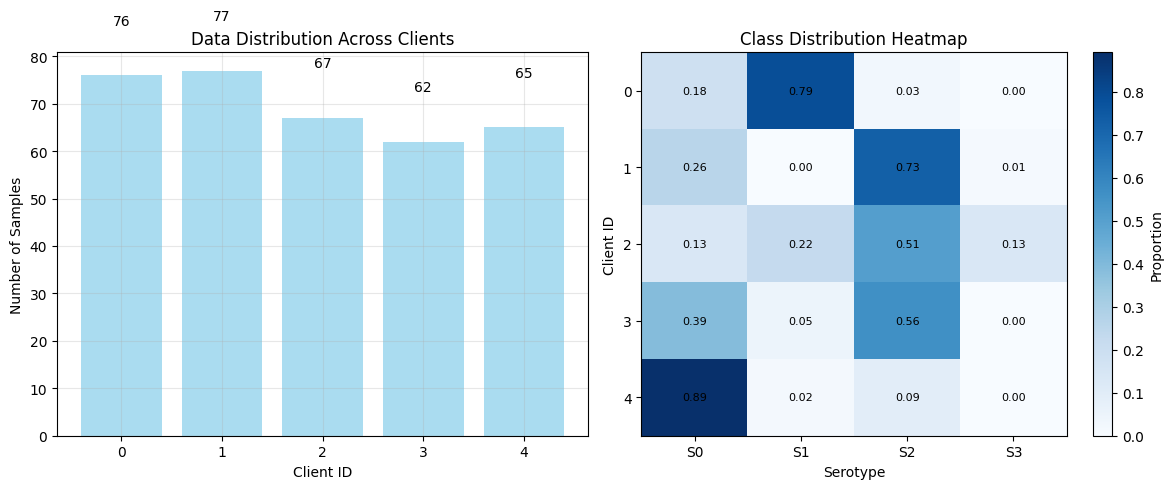

In [9]:
print("="*50)
print("🚀 STARTING FEDERATED LEARNING EXPERIMENT")
print("="*50)

# Configuration
NUM_CLIENTS = 5
PARTITION_TYPE = 'non_iid'  # Options: 'iid', 'non_iid', 'pathological'
FEDERATED_ROUNDS = 15
LOCAL_EPOCHS = 3
LEARNING_RATE = 0.001
BATCH_SIZE = 32

# Split data into train and test
total_samples = len(gene_embeddings)
train_size = int(0.8 * total_samples)
test_size = total_samples - train_size

# Create indices for splitting
indices = torch.randperm(total_samples)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_embeddings = gene_embeddings[train_indices]
train_labels = labels[train_indices]
test_embeddings = gene_embeddings[test_indices]
test_labels = labels[test_indices]

print(f"📊 Data split:")
print(f"   Training: {len(train_embeddings)} samples")
print(f"   Testing:  {len(test_embeddings)} samples")

# Create test dataset (common for all evaluations)
test_dataset = GeneDataset(test_embeddings, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Partition training data among clients
client_datasets = partition_data_advanced(
    train_embeddings, train_labels, 
    num_clients=NUM_CLIENTS, 
    partition_type=PARTITION_TYPE, 
    alpha=0.5
)

# Visualize data distribution
plot_data_distribution(client_datasets)


In [10]:

print("\n" + "="*50)
print("🎯 TRAINING CENTRALIZED BASELINE")
print("="*50)

# Create full training dataset for centralized training
full_train_dataset = GeneDataset(train_embeddings, train_labels)

# Train centralized model
start_time = time.time()
centralized_model, centralized_history = train_centralized_model(
    full_train_dataset, test_dataset, 
    epochs=FEDERATED_ROUNDS,  # Use same number of epochs as federated rounds
    batch_size=BATCH_SIZE, 
    lr=LEARNING_RATE
)
centralized_time = time.time() - start_time

print(f"⏱️ Centralized training completed in {centralized_time:.2f} seconds")
print(f"🎯 Final centralized test accuracy: {centralized_history['test_accuracies'][-1]:.2f}%")




🎯 TRAINING CENTRALIZED BASELINE
🎯 Training centralized baseline model...
Epoch  5: Loss=0.0398, Train Acc=98.6%, Test Acc=99.8%
Epoch 10: Loss=0.0183, Train Acc=99.6%, Test Acc=99.2%
Epoch 15: Loss=0.0073, Train Acc=99.9%, Test Acc=99.8%
⏱️ Centralized training completed in 13.08 seconds
🎯 Final centralized test accuracy: 99.75%


In [11]:

print("\n" + "="*50)
print("🌐 STARTING FEDERATED LEARNING")
print("="*50)

# Initialize federated server
server = FederatedServer(embedding_dim=1020, num_classes=4)

# Create and add clients
clients = []
for i, client_dataset in enumerate(client_datasets):
    client = FederatedClient(client_id=i, dataset=client_dataset, batch_size=BATCH_SIZE)
    clients.append(client)
    server.add_client(client)

print(f"\n🌐 Federation setup complete with {len(clients)} clients")

# Federated training
print(f"\n🔄 Starting {FEDERATED_ROUNDS} rounds of federated training...")
start_time = time.time()

for round_num in range(FEDERATED_ROUNDS):
    print(f"\n{'='*20} ROUND {round_num + 1} {'='*20}")
    
    round_result = server.train_round(
        local_epochs=LOCAL_EPOCHS,
        lr=LEARNING_RATE,
        client_fraction=1.0  # Use all clients
    )
    
    # Evaluate global model every 5 rounds
    if (round_num + 1) % 5 == 0:
        eval_results = server.evaluate_global_model(test_loader)
        print(f"🎯 Global model test accuracy: {eval_results['test_accuracy']:.2f}%")

federated_time = time.time() - start_time
print(f"\n⏱️ Federated training completed in {federated_time:.2f} seconds")



🌐 STARTING FEDERATED LEARNING
🖥️ Server initialized on cpu
➕ Added client 0 with 76 samples
➕ Added client 1 with 77 samples
➕ Added client 2 with 67 samples
➕ Added client 3 with 62 samples
➕ Added client 4 with 65 samples

🌐 Federation setup complete with 5 clients

🔄 Starting 15 rounds of federated training...

==================== ROUND 1 ====================
🔄 Round with 5/5 clients
  📱 Training client 0... Loss: 1.9039, Acc: 25.0%
  📱 Training client 4... Loss: 0.9915, Acc: 63.5%
  📱 Training client 2... Loss: 0.9576, Acc: 63.5%
  📱 Training client 1... Loss: 0.7191, Acc: 73.4%
  📱 Training client 3... Loss: 0.9642, Acc: 58.3%
  🔄 Performing federated averaging...
  ✅ Round completed - Loss: 1.1195, Accuracy: 56.4%

==================== ROUND 2 ====================
🔄 Round with 5/5 clients
  📱 Training client 1... Loss: 0.4642, Acc: 89.1%
  📱 Training client 4... Loss: 0.8987, Acc: 72.4%
  📱 Training client 2... Loss: 0.5593, Acc: 82.3%
  📱 Training client 0... Loss: 1.5469, Acc

In [12]:

print("\n" + "="*50)
print("📊 FINAL EVALUATION")
print("="*50)

# Evaluate final federated model
final_eval_results = server.evaluate_global_model(test_loader)

print(f"🎯 Final Results Summary:")
print(f"   Centralized Test Accuracy: {centralized_history['test_accuracies'][-1]:.2f}%")
print(f"   Federated Test Accuracy:   {final_eval_results['test_accuracy']:.2f}%")
print(f"   Training Time - Centralized: {centralized_time:.2f}s")
print(f"   Training Time - Federated:   {federated_time:.2f}s")

# Per-class accuracy
print(f"\n🏷️ Per-Class Accuracy (Federated):")
for serotype, acc in final_eval_results['class_accuracies'].items():
    print(f"   {serotype}: {acc:.2f}%")

# Generate detailed classification report
predictions = final_eval_results['predictions']
targets = final_eval_results['targets']

print(f"\n📋 Detailed Classification Report:")
print(classification_report(targets, predictions, 
                          target_names=[f'Serotype {i}' for i in range(4)]))



📊 FINAL EVALUATION
🎯 Final Results Summary:
   Centralized Test Accuracy: 99.75%
   Federated Test Accuracy:   95.00%
   Training Time - Centralized: 13.08s
   Training Time - Federated:   4.33s

🏷️ Per-Class Accuracy (Federated):
   serotype_0: 100.00%
   serotype_1: 100.00%
   serotype_2: 97.30%
   serotype_3: 80.23%

📋 Detailed Classification Report:
              precision    recall  f1-score   support

  Serotype 0       0.97      1.00      0.98        85
  Serotype 1       0.97      1.00      0.98       118
  Serotype 2       0.89      0.97      0.93       111
  Serotype 3       1.00      0.80      0.89        86

    accuracy                           0.95       400
   macro avg       0.96      0.94      0.95       400
weighted avg       0.95      0.95      0.95       400




📊 GENERATING COMPREHENSIVE VISUALIZATIONS


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

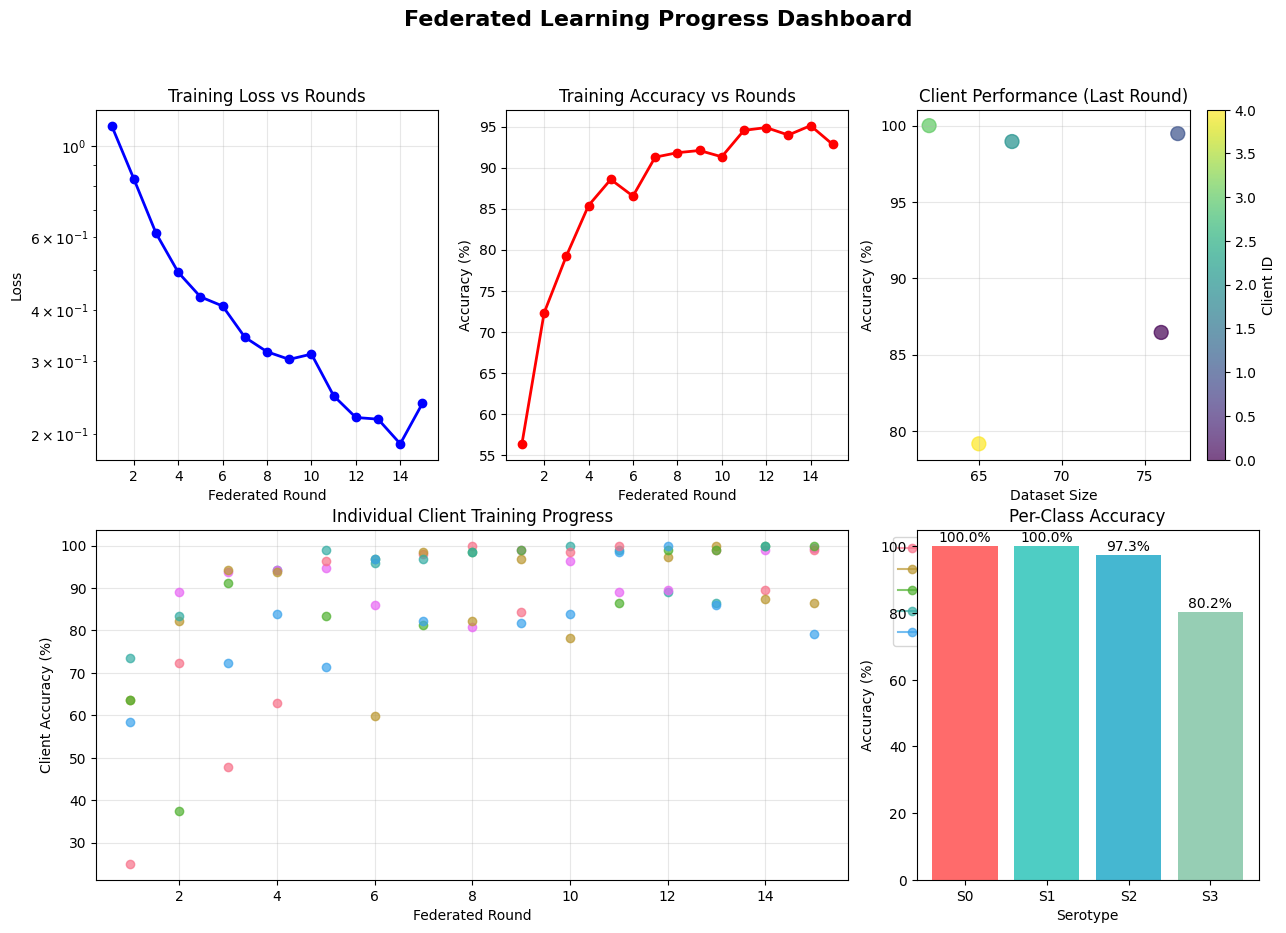

In [13]:

print("\n" + "="*50)
print("📊 GENERATING COMPREHENSIVE VISUALIZATIONS")
print("="*50)

# Plot 1: Comprehensive federated learning dashboard
create_comprehensive_plots(server, final_eval_results)

# Plot 2: Confusion matrix
plot_confusion_matrix(predictions, targets, "Federated Model - Confusion Matrix")

# Plot 3: Training comparison
plot_training_comparison(centralized_history, server.round_history)


In [ ]:

print("\n" + "="*50)
print("📈 STATISTICAL ANALYSIS")
print("="*50)

# Analyze convergence
federated_accuracies = [round_data['round_accuracy'] for round_data in server.round_history]
federated_losses = [round_data['round_loss'] for round_data in server.round_history]

# Calculate convergence metrics
final_accuracy = federated_accuracies[-1]
accuracy_improvement = final_accuracy - federated_accuracies[0]
best_accuracy = max(federated_accuracies)
convergence_round = federated_accuracies.index(best_accuracy) + 1

print(f"📊 Convergence Analysis:")
print(f"   Initial Accuracy: {federated_accuracies[0]:.2f}%")
print(f"   Final Accuracy:   {final_accuracy:.2f}%")
print(f"   Best Accuracy:    {best_accuracy:.2f}% (Round {convergence_round})")
print(f"   Improvement:      {accuracy_improvement:.2f}%")

# Client participation analysis
print(f"\n👥 Client Participation Analysis:")
client_performance = {}
for round_data in server.round_history:
    for client_stat in round_data['client_stats']:
        client_id = client_stat['client_id']
        if client_id not in client_performance:
            client_performance[client_id] = {'accuracies': [], 'losses': [], 'samples': client_stat['samples']}
        client_performance[client_id]['accuracies'].append(client_stat['accuracy'])
        client_performance[client_id]['losses'].append(client_stat['loss'])

for client_id, performance in client_performance.items():
    avg_accuracy = np.mean(performance['accuracies'])
    final_accuracy = performance['accuracies'][-1]
    improvement = final_accuracy - performance['accuracies'][0]
    print(f"   Client {client_id}: Avg={avg_accuracy:.1f}%, Final={final_accuracy:.1f}%, Δ={improvement:+.1f}%")

# Data distribution impact
print(f"\n📊 Data Distribution Impact:")
client_sizes = [len(dataset) for dataset in client_datasets]
size_performance_correlation = np.corrcoef(
    client_sizes, 
    [np.mean(client_performance[i]['accuracies']) for i in range(len(client_sizes))]
)[0, 1]
print(f"   Size-Performance Correlation: {size_performance_correlation:.3f}")


In [ ]:

print("\n" + "="*50)
print("💾 SAVING RESULTS")
print("="*50)

# Save model state dict
torch.save(server.global_model.state_dict(), 'federated_gene_model.pth')
print("✅ Model saved as 'federated_gene_model.pth'")

# Save training history
import json

# Prepare results for JSON serialization
results_summary = {
    'experiment_config': {
        'num_clients': NUM_CLIENTS,
        'partition_type': PARTITION_TYPE,
        'federated_rounds': FEDERATED_ROUNDS,
        'local_epochs': LOCAL_EPOCHS,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE
    },
    'final_results': {
        'centralized_accuracy': float(centralized_history['test_accuracies'][-1]),
        'federated_accuracy': float(final_eval_results['test_accuracy']),
        'centralized_time': float(centralized_time),
        'federated_time': float(federated_time),
        'class_accuracies': {k: float(v) for k, v in final_eval_results['class_accuracies'].items()}
    },
    'convergence_metrics': {
        'initial_accuracy': float(federated_accuracies[0]),
        'final_accuracy': float(final_accuracy),
        'best_accuracy': float(best_accuracy),
        'convergence_round': int(convergence_round),
        'accuracy_improvement': float(accuracy_improvement)
    }
}

with open('federated_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("✅ Results saved as 'federated_results.json'")

# Create summary DataFrame for easy analysis
summary_df = pd.DataFrame({
    'Round': list(range(1, FEDERATED_ROUNDS + 1)),
    'Federated_Loss': federated_losses,
    'Federated_Accuracy': federated_accuracies,
    'Centralized_Accuracy': centralized_history['test_accuracies'][:FEDERATED_ROUNDS]
})

summary_df.to_csv('training_summary.csv', index=False)
print("✅ Training summary saved as 'training_summary.csv'")

print(f"\n🎉 Experiment completed successfully!")
print(f"📊 Key Results:")
print(f"   • Federated Learning achieved {final_eval_results['test_accuracy']:.2f}% accuracy")
print(f"   • Centralized baseline achieved {centralized_history['test_accuracies'][-1]:.2f}% accuracy")
print(f"   • Performance difference: {final_eval_results['test_accuracy'] - centralized_history['test_accuracies'][-1]:+.2f}%")
print(f"   • Training completed with {NUM_CLIENTS} clients using {PARTITION_TYPE} data distribution")


In [ ]:
print("\n" + "="*50)
print("🔬 ADVANCED ANALYSIS (OPTIONAL)")
print("="*50)

def analyze_client_contribution():
    """Analyze individual client contributions to global model"""
    print("🔍 Analyzing client contributions...")
    
    # Calculate client weight in federated averaging
    total_samples = sum(len(dataset) for dataset in client_datasets)
    client_weights = [len(dataset) / total_samples for dataset in client_datasets]
    
    # Client contribution analysis
    print("Client | Samples | Weight | Avg Accuracy | Contribution Score")
    print("-" * 65)
    
    for i, (weight, performance) in enumerate(zip(client_weights, client_performance.values())):
        avg_acc = np.mean(performance['accuracies'])
        contribution_score = weight * avg_acc / 100  # Normalized contribution
        print(f"  {i:2d}   |  {performance['samples']:4d}   | {weight:.3f} |    {avg_acc:.1f}%    |     {contribution_score:.3f}")

def communication_efficiency_analysis():
    """Analyze communication efficiency"""
    print("\n📡 Communication Efficiency Analysis:")
    
    # Calculate model size (number of parameters)
    total_params = sum(p.numel() for p in server.global_model.parameters())
    model_size_mb = total_params * 4 / (1024 * 1024)  # Assuming float32
    
    # Total communication rounds
    total_communication_rounds = FEDERATED_ROUNDS * NUM_CLIENTS * 2  # Up and down
    total_data_transferred = total_communication_rounds * model_size_mb
    
    print(f"   Model parameters: {total_params:,}")
    print(f"   Model size: {model_size_mb:.2f} MB")
    print(f"   Total communication rounds: {total_communication_rounds}")
    print(f"   Total data transferred: {total_data_transferred:.2f} MB")
    print(f"   Communication per client per round: {model_size_mb * 2:.2f} MB")

# Run advanced analysis
analyze_client_contribution()
communication_efficiency_analysis()

print("\n🎯 Advanced analysis completed!")
print("🎉 Full federated learning experiment finished successfully!")